In [1]:
import torch
from rudalle import get_vae
from rudalle.utils import seed_everything

import sys
sys.path.insert(0, '../../deep_rl_zoo')
sys.path.insert(0, '../src/')
sys.path.insert(0, '../')

import os
from glob import glob
from os.path import join
from datetime import datetime
import bitsandbytes as bnb
from torch.utils.data import Dataset, DataLoader
import torchvision
import transformers
import more_itertools
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T
from tqdm.auto import tqdm
from einops import rearrange
import youtokentome as yttm
import torchvision

from rudalle.image_prompts import ImagePrompts

from rudolph.model import get_rudolph_model, ruDolphModel, FP16Module
from rudolph import utils
from rudolph.model.utils import get_attention_mask
from rudalle import get_tokenizer, get_vae
from rudolph.api import ruDolphApi

import datasets
import random
import h5py
from PIL import Image
import wandb

from collections import deque
import datetime
import gym
from gym.spaces import Box
import cv2
from deep_rl_zoo.networks.dqn import RainbowDqnMlpNet, RainbowDqnConvNet, R2d2DqnConvNet
from deep_rl_zoo import main_loop
from deep_rl_zoo.checkpoint import PyTorchCheckpoint
from deep_rl_zoo import gym_env
from deep_rl_zoo import greedy_actors
import deep_rl_zoo.types as types_lib
from moviepy.editor import ImageSequenceClip
import pandas as pd
import webdataset as wds
import s3dataset
import io
from client_lib import save_aws_credentials,S3CopyJob
import rudolph

In [2]:
rudolph.__file__

'../src/rudolph/__init__.py'

In [3]:
!pip show bitsandbytes
# Version: 0.36.0.post2
# Version: 0.35.4

Name: bitsandbytes
Version: 0.35.4
Summary: 8-bit optimizers and matrix multiplication routines.
Home-page: https://github.com/TimDettmers/bitsandbytes
Author: Tim Dettmers
Author-email: dettmers@cs.washington.edu
License: MIT
Location: /home/jovyan/.imgenv-rl-models-a100-2-0-0/lib/python3.7/site-packages
Requires: 
Required-by: 


In [4]:
import bitsandbytes
bitsandbytes.__file__

'/home/jovyan/.imgenv-rl-models-a100-2-0-0/lib/python3.7/site-packages/bitsandbytes/__init__.py'

In [5]:
torch.cuda.set_device(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
model = get_rudolph_model('350M', pretrained=True, fp16=False, device=device) #2.7B #1.3B #350M

Russian Diffusion On Language Picture Hyper-modality (RuDOLPH 🦌🎄☃️) 350M is a fast and light text-image-text transformer (350M GPT-3) designed for a quick and easy fine-tuning setup for the solution of various tasks: from generating images by text description and image classification to visual question answering and more. 
This model demonstrates the power of Hyper-modality Transformers.


In [7]:
tokenizer = get_tokenizer()
vae = get_vae(dwt=False).to(device)

tokenizer --> ready
Working with z of shape (1, 256, 32, 32) = 262144 dimensions.


vae --> ready


In [8]:
class Args():
    def __init__(self, model, checkpoint_path):
        self.device = model.get_param('device')
        self.l_text_seq_length = model.get_param('l_text_seq_length')
        self.r_text_seq_length = model.get_param('r_text_seq_length')
        self.image_tokens_per_dim = model.get_param('image_tokens_per_dim')
        self.image_seq_length = model.get_param('image_seq_length')
        self.epochs = 2
        self.save_path= checkpoint_path
        self.model_name = 'rudolph_sberquad_'
        self.save_every = 500
        self.bs = 4
        self.clip = 1.0
        self.lr = 2e-5
        self.wandb = False
        self.lt_loss_weight = 0.01
        self.img_loss_weight = 0.01
        self.rt_loss_weight = 7
        self.image_size = self.image_tokens_per_dim * 8
        
checkpoint_path = '../checkpoints/350_S3_FBC/'
args = Args(model, checkpoint_path)
args.bs = 24 #batch_size 4 default ##################################################################
args.epochs = 10
args.wandb = False
if not os.path.exists(args.save_path):
    os.makedirs(args.save_path)

In [9]:
SPC_TOKENS = {
    '<LT_UNK>': 16384,
    '<RT_UNK>': 16385,
    '<LT_T2I>': 16386,
    '<LT_I2T>': 16387,
    '<LT_T2T>': 16388,
    '<RT_I2T>': 16389,
    
    '<LT_TQA>': 16390,
    '<RT_TQA>': 16391,
    
    '<LT_RLA>': 16392,
    '<RT_RLA>': 16393,
}
for i in range(18):
    SPC_TOKENS['ATARI_'+str(i)] = 16394 + i

In [10]:
api = ruDolphApi(model, tokenizer, vae, bs=48)

In [11]:
api.ignore_ids

[3, 2, 1, 0, -1, 16384, 16385, 16386, 16387, 16388, 16389]

In [12]:
import random
import torch
import pickle
#from fixed_replay_buffer import FixedReplayBuffer

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [13]:
seed = 123
set_seed(seed)

class RLDataset(Dataset):
    spc_id = -1
    
    def __init__(self, states, actions, tokenizer, api, args):
        self.tokenizer = tokenizer
        self.api = api
        self.states = states
        self.args = args
        self.spc_tokens = SPC_TOKENS
        
        
        self.actions = actions
        #self.states = data
        #self.data_path = data_path
        #np.concatenate([np.array(self.hf_Frostbite[i]['obs']) for i in self.hf_Frostbite], axis=0)
        
    def __len__(self):
        return len(self.actions)
    
    def __getitem__(self, item):
        
        left_special_token = '<LT_RLA>'
        right_special_token = '<RT_RLA>'
        
        lt = torch.zeros(self.args.l_text_seq_length,dtype=torch.int32)
        lt[0] = 2
        lt[1] = self.spc_tokens[left_special_token]
        lt[2] = 3
        
        img = self.states[item]#self.states[item]
        img = np.vstack((np.hstack((img[0],img[1])),np.hstack((img[2],img[3]))))
        img = Image.fromarray(img)
        img = self.api.image_transform(img)
        img = img.unsqueeze(0).to(self.api.device)
        img = self.api.vae.get_codebook_indices(img, disable_gumbel_softmax=True)[0]
        
        rt = torch.zeros(self.args.r_text_seq_length,dtype=torch.int32)
        rt[0] = 2
        rt[1] = self.spc_tokens[right_special_token]
        rt[2] = self.spc_tokens['ATARI_{}'.format(self.actions[item])]
        rt[3] = 3
        
        
        #left_tokens = self.actions[item]
        #right_tokens = self.states[item]
        
        return lt, img, rt

In [14]:
def freeze(
    model,
    freeze_emb=False,
    freeze_ln=False,
    freeze_attn=True,
    freeze_ff=True,
    freeze_other=False,
):
    for name, p in model.module.named_parameters():
        name = name.lower()
        if 'ln' in name or 'norm' in name:
            p.requires_grad = not freeze_ln
        elif 'embeddings' in name:
            p.requires_grad = not freeze_emb
        elif 'mlp' in name:
            p.requires_grad = not freeze_ff
        elif 'attn' in name:
            p.requires_grad = not freeze_attn
        else:
            p.requires_grad = not freeze_other
    return model

In [15]:
def load_checkpoint(model, optimizer, losslogger, filename='checkpoint.pt'):
    # Note: Input model & optimizer should be pre-defined.  This routine only updates their states.
    start_epoch = 0
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        losslogger = checkpoint['losslogger']
        print("=> loaded checkpoint '{}' (epoch {})"
                  .format(filename, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))

    return model, optimizer, start_epoch, losslogger

In [16]:
def preprocess_s3_frame(item):
    
    left_special_token = '<LT_RLA>'
    right_special_token = '<RT_RLA>'

    lt = torch.zeros(args.l_text_seq_length,dtype=torch.int32)
    #lt[0] = 2
    #lt[1] = SPC_TOKENS[left_special_token]
    #lt[2] = 3

    img = Image.open(io.BytesIO(item['data']))  
    img = api.image_transform(img)
    img = img.unsqueeze(0).to(api.device)
    img = api.vae.get_codebook_indices(img, disable_gumbel_softmax=True)[0]

    rt = torch.zeros(args.r_text_seq_length,dtype=torch.int32)
    rt[0] = 2
    rt[1] = SPC_TOKENS[right_special_token]
    rt[2] = SPC_TOKENS['ATARI_{}'.format(item['action'])]
    rt[3] = 3
    return lt,img,rt

In [17]:
storage_options = {
    "anon": False,
    'key': 'officecds-user01',
    'secret':'jym0FuboUnR5VsPmCgYTGv1QQfglYZhPRWbEfS59',
    'client_kwargs': {
        'endpoint_url':'https://s3pd12.sbercloud.ru'
    }
}
s3dataset.init_webdataset(storage_options)
game = 'Breakout'
urls = ['s3://officecds-bucket01/datasets_v3/rl_atari_dataset/atari_{}/atari_{}_tr_{}.tar'.format(game.lower(),game.lower(),str(10000+i)[1:]) for i in range(1,500)]

s3_dataset = wds.WebDataset(
    urls, 
    handler=wds.warn_and_continue).shuffle(10000)
s3_dataset = s3_dataset.map(preprocess_s3_frame)
train_dataloader = DataLoader(s3_dataset, batch_size=args.bs, drop_last=True)
batch = next(iter(train_dataloader))

In [18]:
def take_fire_action(env):
    """Some games requires the agent to press 'FIRE' to start the game once loss a life."""
    assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
    s_t, _, _, _ = env.step(1)
    return s_t

def check_atari_env(env):
    """Check if is atari env and has fire action."""
    has_fire_action = False
    lives = 0
    try:
        lives = env.ale.lives()
        if env.unwrapped.get_action_meanings()[1] == 'FIRE':
            has_fire_action = True
    except AttributeError:
        pass

    return has_fire_action, lives

eval_env = gym_env.create_atari_environment(
                env_name=game,
                screen_height=84,
                screen_width=84,
                frame_skip=4,
                frame_stack=4,
                max_episode_steps=28000,
                seed=1,
                noop_max=30,
                terminal_on_life_loss=False,
                clip_reward=False,
            )

def rudolph_step(observation,model):
    left_special_token = '<LT_RLA>'
    right_special_token = '<RT_RLA>'
    
    lt = torch.zeros(args.l_text_seq_length,dtype=torch.int32)
    #lt[0] = 2
    #lt[1] = SPC_TOKENS[left_special_token]
    #lt[2] = 3
    
    rt = torch.zeros(2, dtype=torch.int32)
    rt[0] = 2
    rt[1] = SPC_TOKENS[right_special_token]
    
    img = np.vstack((np.hstack((observation[0],observation[1])),np.hstack((observation[2],observation[3]))))
    img = Image.fromarray(img)
    img = api.image_transform(img)
    img = img.unsqueeze(0).to(api.device)
    image_input_ids_text = api.vae.get_codebook_indices(img, disable_gumbel_softmax=True)[0]

    attention_mask_text = get_attention_mask(1, args.l_text_seq_length,args.image_tokens_per_dim,2, args.device)
    #attention_mask_text[:,:,args.l_text_seq_length:-args.r_text_seq_length,:]*=0
    
    input_ids_text = torch.cat((lt.to(args.device).unsqueeze(0), image_input_ids_text.to(args.device).unsqueeze(0), rt.to(args.device).unsqueeze(0)), dim=1)
    
    with torch.no_grad():
        logits = model(input_ids_text, attention_mask_text)
    # Ниже код, в котором выполняется семплирование из выдаваемого моделью распределения
    
    #distribution = torch.softmax(logits[0][:, -1, SPC_TOKENS['ATARI_0']:SPC_TOKENS['ATARI_0']+4], 1)
    #a_t = torch.multinomial(distribution, 1).item()
    a_t = torch.argmax(logits[0][:, -1, SPC_TOKENS['ATARI_0']:SPC_TOKENS['ATARI_0']+4]).item()
    return a_t
    

A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]


In [19]:
def get_atari_reward(model):
    observation = eval_env.reset()
    should_fire, lives = check_atari_env(eval_env)
    if should_fire:
        observation = take_fire_action(eval_env)
    sum_rewards = []

    observation = eval_env.reset()
    should_fire, lives = check_atari_env(eval_env)
    if should_fire:
        observation = take_fire_action(eval_env)
    num_actions = eval_env.action_space.n

    idd = 0; sum_reward = 0; frames = []
    while True:
        a_t = rudolph_step(observation,model)  
        observation, reward, done, info = eval_env.step(a_t); idd+=1; first_step = False

        sum_reward+=reward
        # Take fire action after loss a life
        if should_fire and not done and lives != info['lives']:
            lives = info['lives']
            observation = take_fire_action(eval_env)

        if done:
            sum_rewards.append(sum_reward)
            print('Done with steps: ',idd,' Sum_reward: ',sum_reward)
            return np.mean(sum_rewards)  
    return np.mean(sum_rewards)

In [20]:
get_atari_reward(model)

Done with steps:  117  Sum_reward:  0.0


0.0

In [21]:
def train(model, optimizer, scheduler, args: Args, train_dataloader, from_checkpoints = False):
    """
      args - arguments for training

      train_dataloader - SQuADDataset class with text_q - text_a pairs in batch
      """
    loss_logs = []

    t_steps = 10632*args.epochs#len(train_dataloader)*args.epochs
    progress = tqdm(total = t_steps, desc='🦌🦌🦌finetuning process🦌🦌🦌')

    save_counter = 0
    start_epoch = 0

    if from_checkpoints:
        model, optimizer, start_epoch, loss_logs = load_checkpoint(model, optimizer, loss_logs, filename=os.path.join(args.save_path,f"rudolph_sberquad_state_35500.pt"))

    for epoch in range(start_epoch, args.epochs):

      for encoded_left_text, img_tokens, encoded_right_text in train_dataloader: #, prompt, word

        bs_text = encoded_left_text.shape[0]

        save_counter+=1

        model.zero_grad()

        image_seq_length = args.image_tokens_per_dim ** 2
        total_seq_length = args.l_text_seq_length + image_seq_length + args.r_text_seq_length

        attention_mask_text = get_attention_mask(bs_text, args.l_text_seq_length,
                                             args.image_tokens_per_dim, 
                                             args.r_text_seq_length, args.device)
        #attention_mask_text[:,:,args.l_text_seq_length+int(args.l_text_seq_length/2):-args.r_text_seq_length,:]*=0

        image_input_ids_text = img_tokens#torch.zeros((bs_text, image_seq_length), dtype=torch.int32).to(args.device)

        input_ids_text = torch.cat((encoded_left_text.to(args.device), image_input_ids_text.to(args.device), encoded_right_text.to(args.device)), dim=1)

        loss, loss_values = model.forward(input_ids_text, attention_mask_text, 
                                                         lt_loss_weight=args.lt_loss_weight,
                                                         img_loss_weight=args.img_loss_weight, 
                                                         rt_loss_weight=args.rt_loss_weight, return_loss=True)


        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(),args.clip)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        if save_counter % args.save_every == 0:
            print(f'Saving checkpoint here {args.model_name}_rudolph_{save_counter}.pt')
            plt.plot(loss_logs)
            plt.show()
            state = {'epoch': epoch + 1, 'state_dict': model.state_dict(),
                     'optimizer': optimizer.state_dict(), 'losslogger': loss_logs}
            #torch.save(
            #    model.state_dict(),
            #    os.path.join(args.save_path,f"{args.model_name}rudolph_{save_counter}.pt"))

            BREAKOUT_REWARD = get_atari_reward(model)
            wandb.log({"Reward": BREAKOUT_REWARD})
            #torch.save(
            #    state,
            #    os.path.join(args.save_path,f"{args.model_name}state_{save_counter}.pt"))
        if args.wandb:
            wandb.log({"loss":  loss.item()})

        loss_logs+=[loss.item()]

        wandb.log({"loss": loss.item()})

        progress.update()
        progress.set_postfix({"loss": loss.item()})

    print(f'Complitly tuned and saved here  {args.model_name}__textqa_last.pt')
    plt.plot(loss_logs)
    plt.show()
    plt.savefig('rudolph_loss_13B_fromstart.png')
    torch.save(
        model.state_dict(),
        os.path.join(args.save_path,f"{args.model_name}textqa_last.pt")
    )
        

In [22]:
model.train()
optimizer = bnb.optim.Adam8bit(model.parameters(), lr=args.lr)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=args.lr, final_div_factor=500, 
    steps_per_epoch=10632, epochs=args.epochs    #len(train_dataloader)
)

In [23]:
# '8909_CLIP_VAL_dense', reinit=True
import os, wandb
os.environ['WANDB_MODE'] = 'online'
os.environ['WANDB_API_KEY'] = '77b33f530c461728a2fb12eeb694e04811d2d960'

wandb.init(project="multi", entity="cds",config=args, name='RLdolph_S3_0l_Falsei_1:2_stW_noFrz_noFP16') #, id='23g9glh9', reinit=False, resume=True, 
wandb.watch(model)

wandb: Currently logged in as: alstar (cds). Use `wandb login --relogin` to force relogin


[]

In [24]:
#checkpoint_path = '../checkpoints/light_last.pt'
#checkpoint_path = '/home/jovyan/Aleksei_RL/inference/model/light_last.pt' 
#checkpoint_path = '/home/jovyan/Aleksei_RL/inference/model/350_S3_FBC/rudolph_sberquad_rudolph_106000.pt'
#checkpoint = torch.load(checkpoint_path, map_location=device)
#model.load_state_dict(checkpoint)

🦌🦌🦌finetuning process🦌🦌🦌:   0%|          | 0/106320 [00:00<?, ?it/s]

Saving checkpoint here rudolph_sberquad__rudolph_500.pt


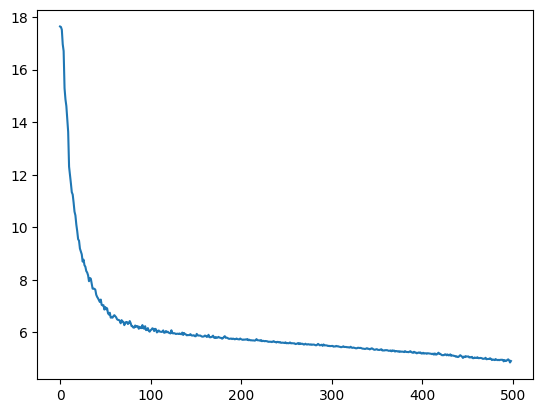

Done with steps:  120  Sum_reward:  0.0
Saving checkpoint here rudolph_sberquad__rudolph_1000.pt


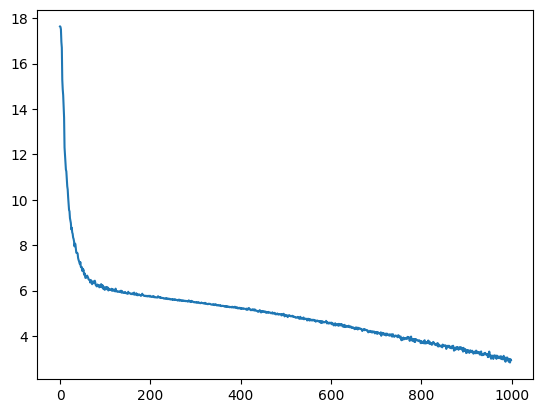

Done with steps:  120  Sum_reward:  0.0
Saving checkpoint here rudolph_sberquad__rudolph_1500.pt


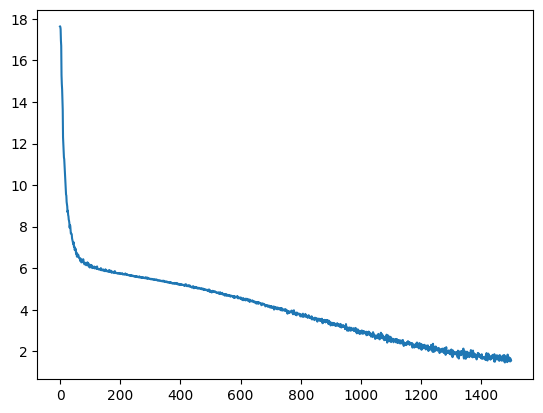

Done with steps:  120  Sum_reward:  0.0
Saving checkpoint here rudolph_sberquad__rudolph_2000.pt


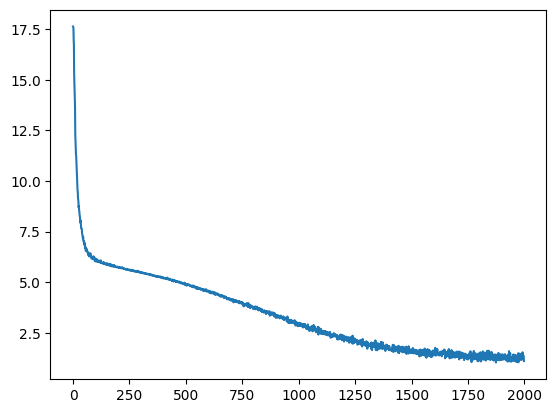

Done with steps:  117  Sum_reward:  0.0
Saving checkpoint here rudolph_sberquad__rudolph_2500.pt


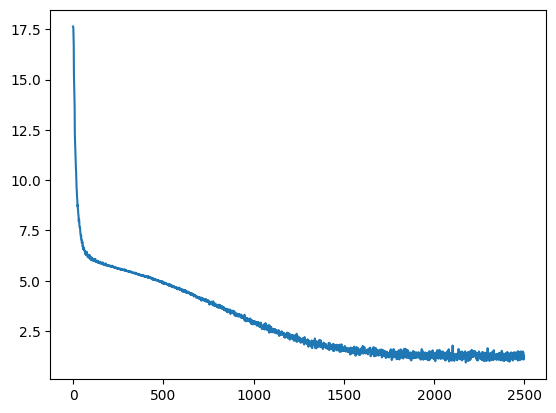

Done with steps:  117  Sum_reward:  0.0
Saving checkpoint here rudolph_sberquad__rudolph_3000.pt


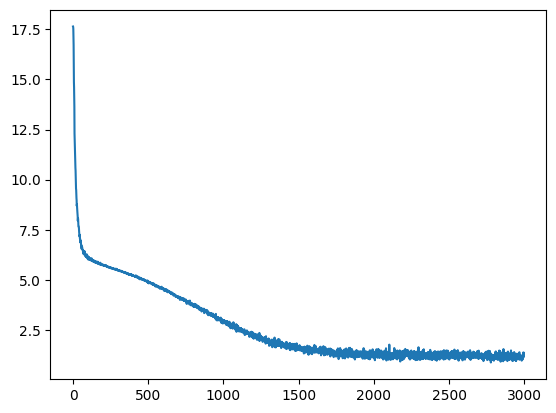

Done with steps:  117  Sum_reward:  0.0
Saving checkpoint here rudolph_sberquad__rudolph_3500.pt


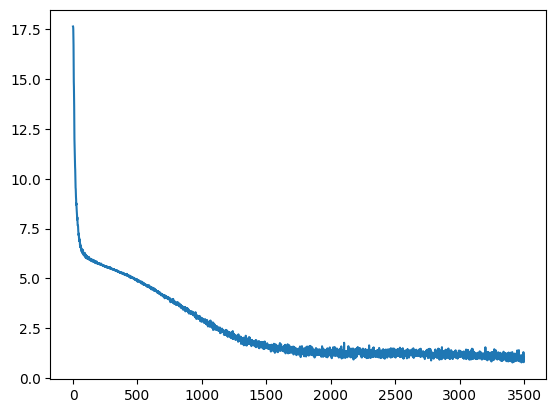

Done with steps:  120  Sum_reward:  0.0
Saving checkpoint here rudolph_sberquad__rudolph_4000.pt


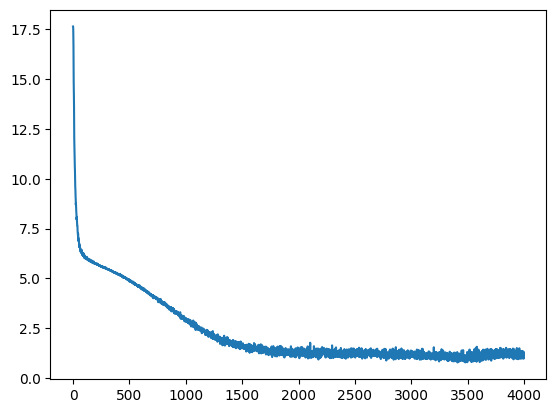

Done with steps:  117  Sum_reward:  0.0
Saving checkpoint here rudolph_sberquad__rudolph_4500.pt


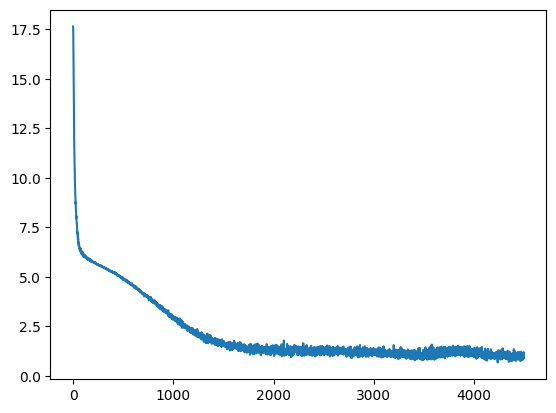

Done with steps:  262  Sum_reward:  11.0
Saving checkpoint here rudolph_sberquad__rudolph_5500.pt


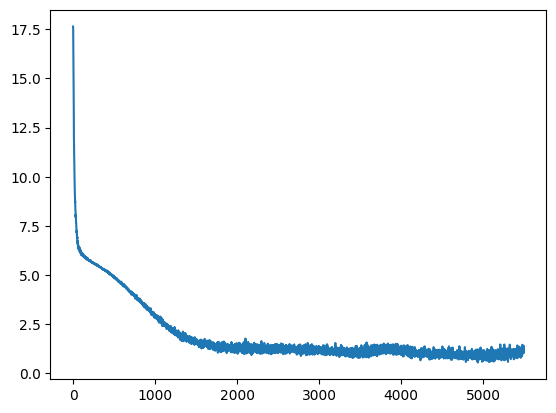

Done with steps:  146  Sum_reward:  1.0
Saving checkpoint here rudolph_sberquad__rudolph_6000.pt


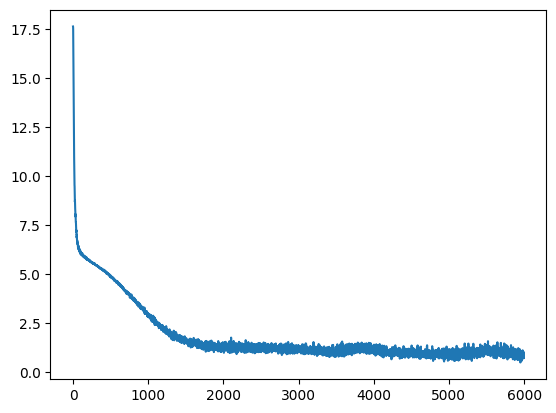

Done with steps:  120  Sum_reward:  0.0
Saving checkpoint here rudolph_sberquad__rudolph_6500.pt


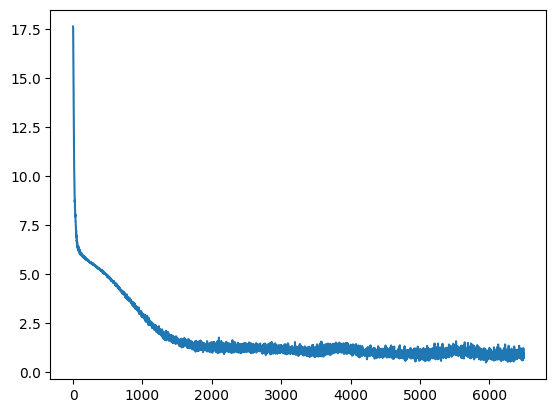

Done with steps:  178  Sum_reward:  2.0
Saving checkpoint here rudolph_sberquad__rudolph_7000.pt


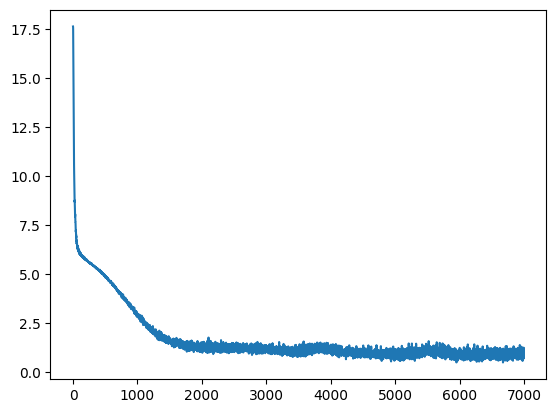

Done with steps:  332  Sum_reward:  6.0
Saving checkpoint here rudolph_sberquad__rudolph_7500.pt


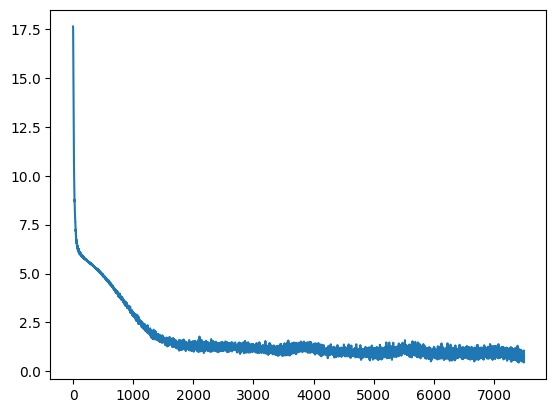

Done with steps:  205  Sum_reward:  3.0
Saving checkpoint here rudolph_sberquad__rudolph_8000.pt


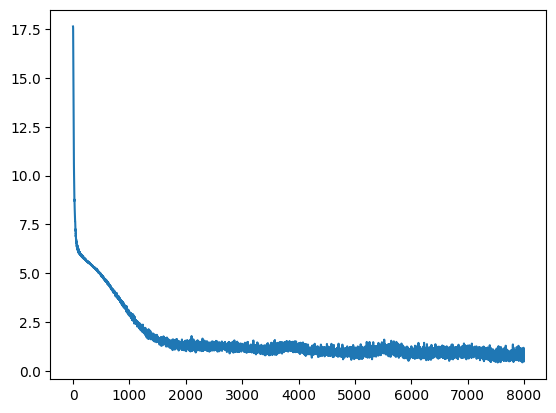

Done with steps:  276  Sum_reward:  12.0
Saving checkpoint here rudolph_sberquad__rudolph_8500.pt


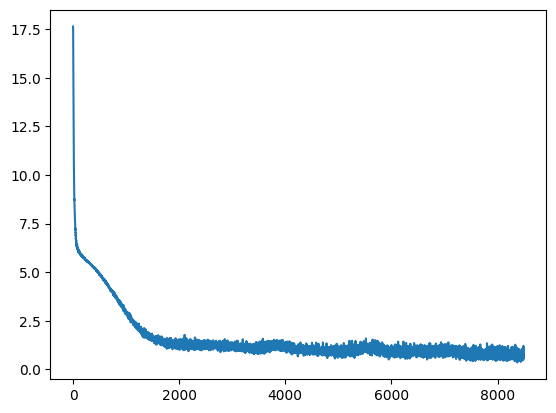

Done with steps:  163  Sum_reward:  1.0
Saving checkpoint here rudolph_sberquad__rudolph_9000.pt


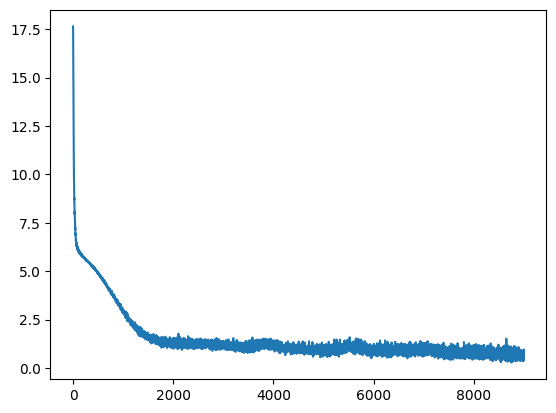

Done with steps:  119  Sum_reward:  0.0
Saving checkpoint here rudolph_sberquad__rudolph_9500.pt


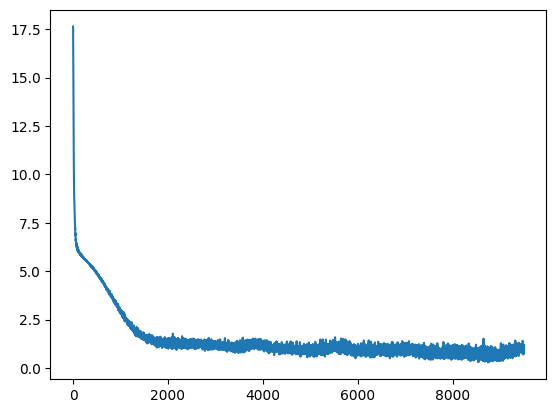

Done with steps:  228  Sum_reward:  3.0
Saving checkpoint here rudolph_sberquad__rudolph_10000.pt


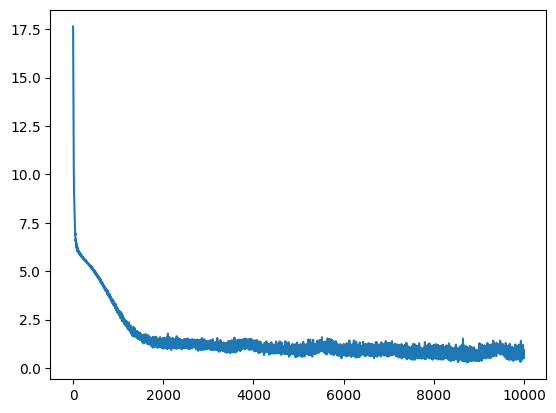

Done with steps:  338  Sum_reward:  10.0
Saving checkpoint here rudolph_sberquad__rudolph_10500.pt


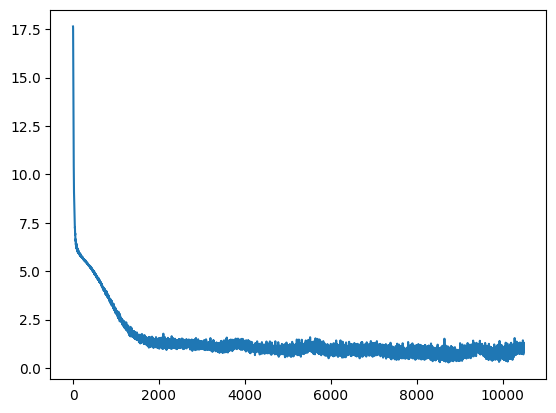

Done with steps:  146  Sum_reward:  1.0
Saving checkpoint here rudolph_sberquad__rudolph_11000.pt


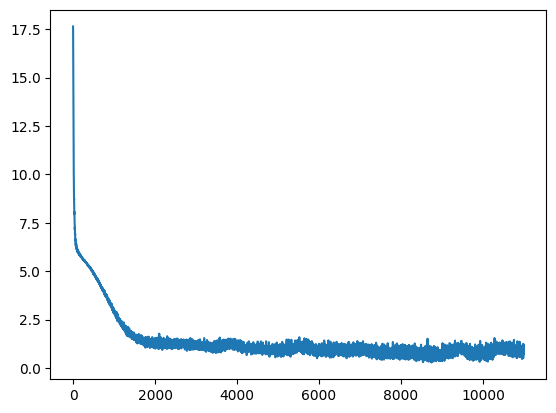

Done with steps:  196  Sum_reward:  2.0
Saving checkpoint here rudolph_sberquad__rudolph_11500.pt


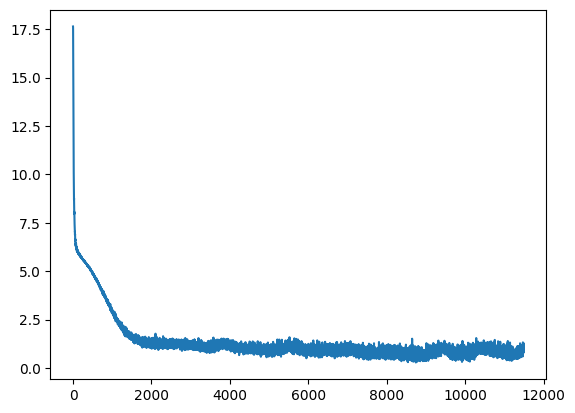

Done with steps:  176  Sum_reward:  2.0


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Saving checkpoint here rudolph_sberquad__rudolph_15500.pt


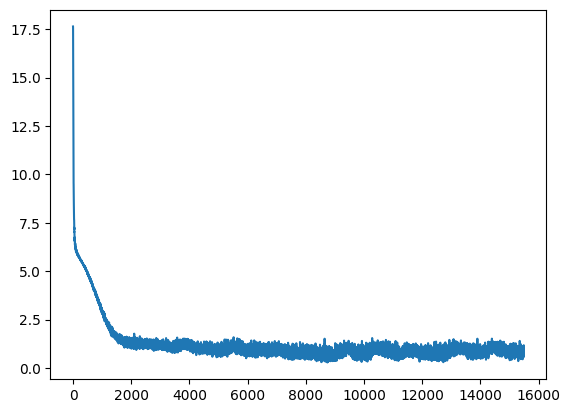

Done with steps:  452  Sum_reward:  8.0
Saving checkpoint here rudolph_sberquad__rudolph_16000.pt


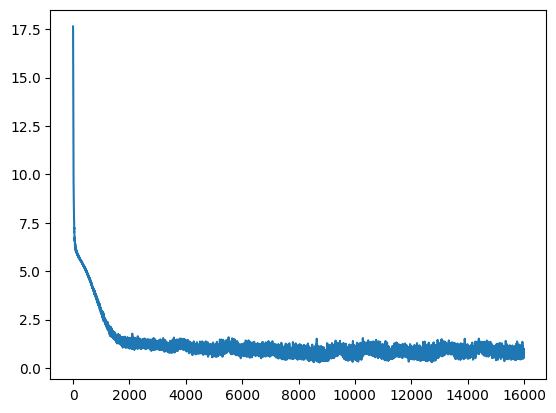

Done with steps:  778  Sum_reward:  49.0
Saving checkpoint here rudolph_sberquad__rudolph_16500.pt


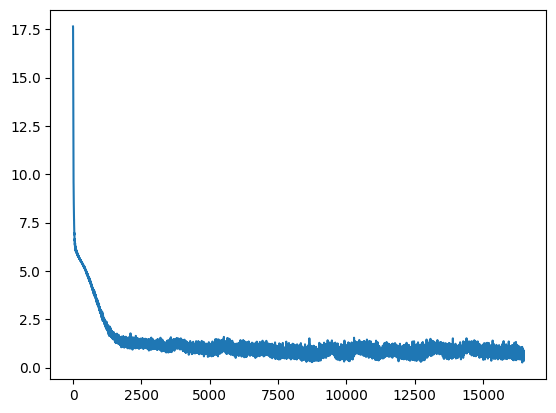

Done with steps:  401  Sum_reward:  12.0
Saving checkpoint here rudolph_sberquad__rudolph_17000.pt


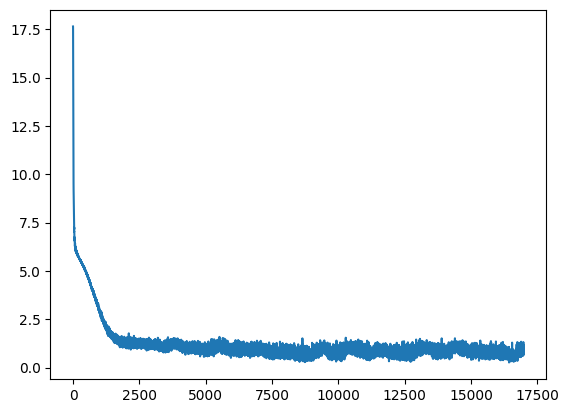

Done with steps:  368  Sum_reward:  17.0
Saving checkpoint here rudolph_sberquad__rudolph_17500.pt


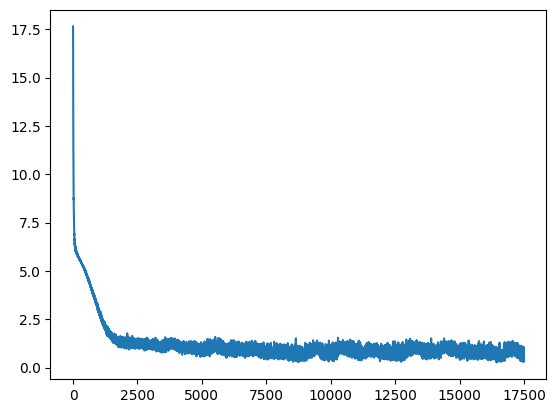

Done with steps:  120  Sum_reward:  0.0
Saving checkpoint here rudolph_sberquad__rudolph_18000.pt


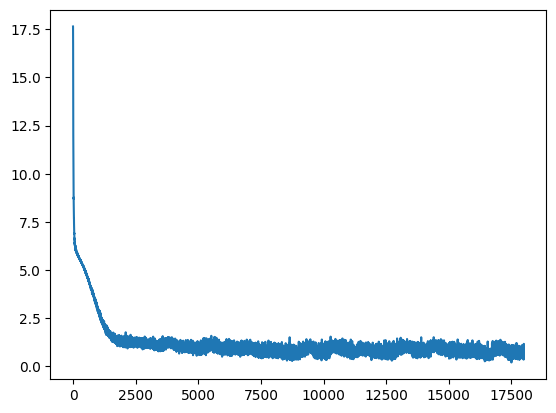

Done with steps:  524  Sum_reward:  12.0
Saving checkpoint here rudolph_sberquad__rudolph_18500.pt


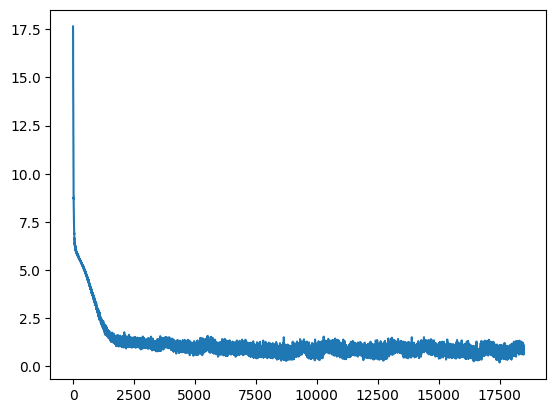

Done with steps:  504  Sum_reward:  15.0
Saving checkpoint here rudolph_sberquad__rudolph_19000.pt


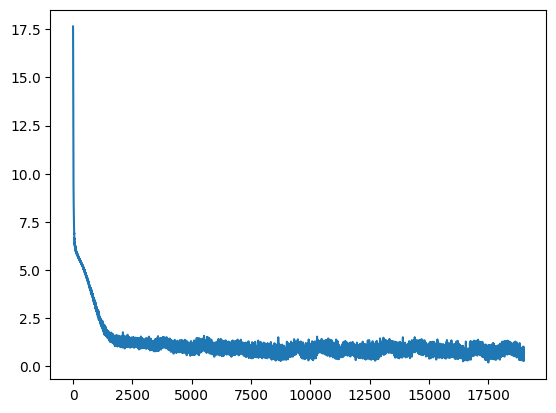

Done with steps:  293  Sum_reward:  4.0
Saving checkpoint here rudolph_sberquad__rudolph_19500.pt


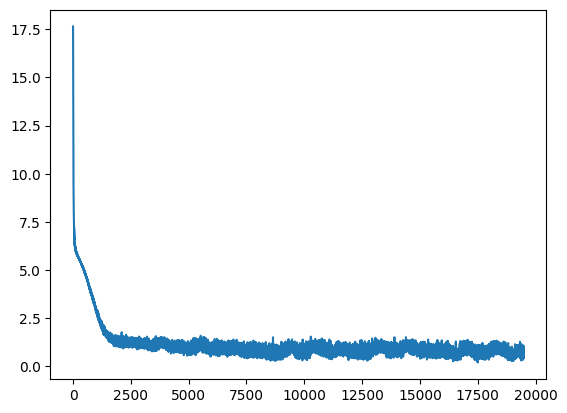

Done with steps:  425  Sum_reward:  8.0


In [ ]:
"""
model = freeze(
    model=model,
    freeze_emb=False,
    freeze_ln=False,
    freeze_attn=True,
    freeze_ff=True,
    freeze_other=False,
) 
"""


train(model, optimizer, scheduler, args, train_dataloader)

In [ ]:
list(model.parameters())